# <center> Image Sentiment Classification <center>

## Importing important libraries and setting up dependencies

In [1]:
import tensorflow as tf
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# Avoiding OOM error by limiting vram use by model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Removing Noisy Images

In [5]:
import cv2
import imghdr

In [6]:
data_dir = 'data'

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
# We are going to use os to go through our data
#os.listdir(os.path.join(data_dir, 'Happy'))

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## Load Data

In [54]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 164 files belonging to 2 classes.


In [49]:
data_iterator = data.as_numpy_iterator()

In [24]:
# Images represented as numpy arrays
batch = data_iterator.next()

In [25]:
batch[0].shape

(32, 256, 256, 3)

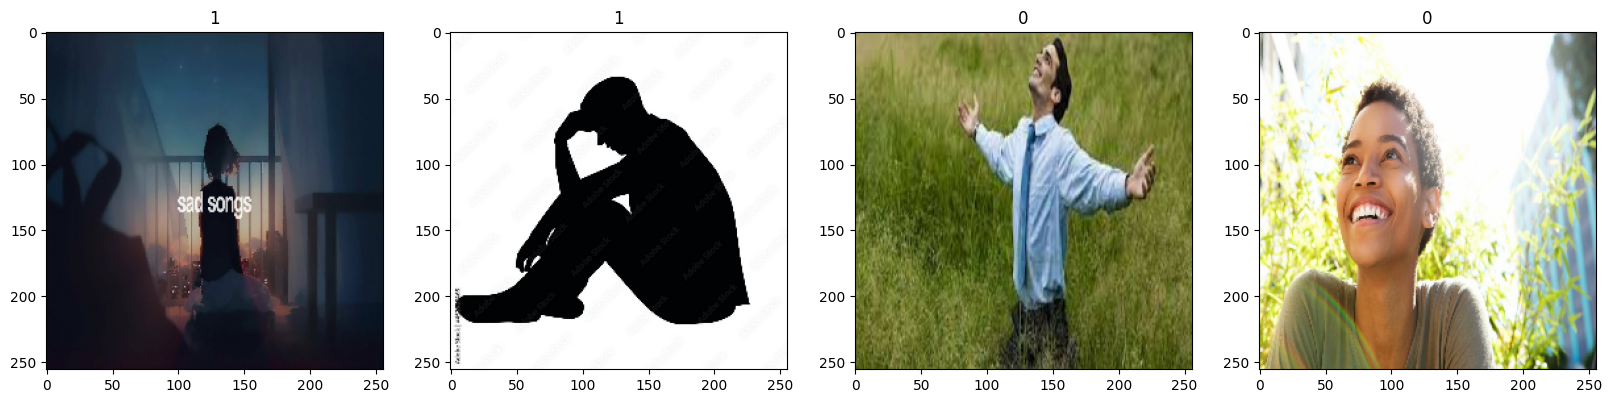

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocessing/Scaling

In [55]:
# we scale the image values between 0 and 1 instead of 0-255 because it helps our deep learning model genralize faster and produce better results
data = data.map(lambda x,y: (x/255, y))

In [56]:
scaled_iterator = data.as_numpy_iterator()

In [57]:
batch = scaled_iterator.next()

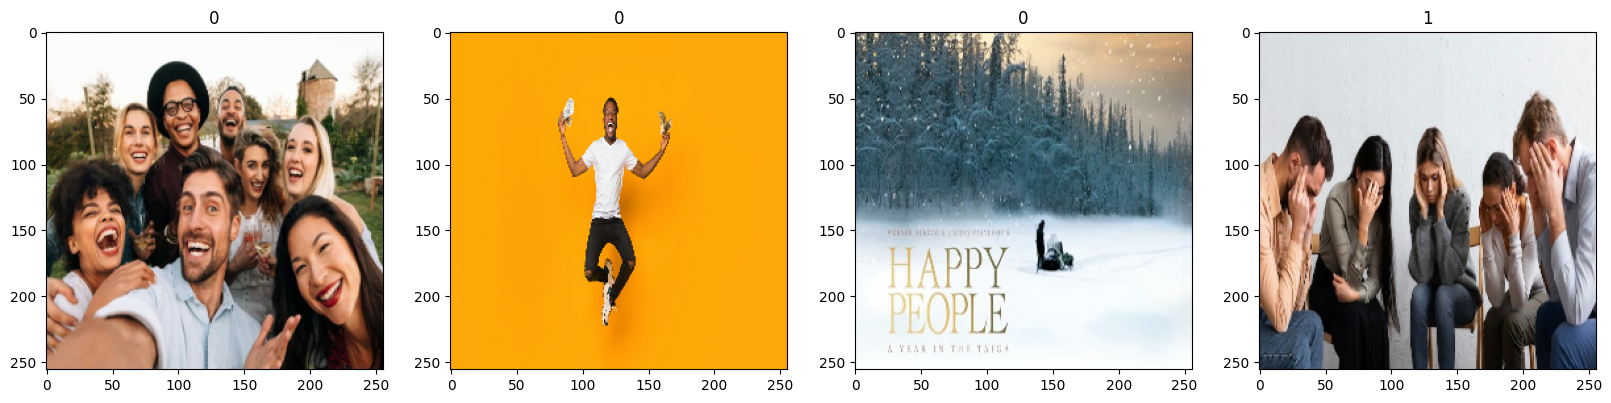

In [58]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## Train Test Split

In [59]:
len(data)

6

In [64]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [70]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [71]:
len(train)

4

## Deep Learning Model

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [76]:
model = Sequential()

In [77]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [78]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [79]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)            

## Training the model

In [80]:
logdir='logs'

In [81]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [82]:

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 14s 706ms/step - loss: 1.1579 - accuracy: 0.4844 - val_loss: 0.7771 - val_accuracy: 0.4062
Epoch 2/20
4/4 [==============================] - 3s 470ms/step - loss: 0.6895 - accuracy: 0.6484 - val_loss: 0.6530 - val_accuracy: 0.6562
Epoch 3/20
4/4 [==============================] - 3s 633ms/step - loss: 0.6250 - accuracy: 0.7578 - val_loss: 0.5912 - val_accuracy: 0.8125
Epoch 4/20
4/4 [==============================] - 4s 620ms/step - loss: 0.5709 - accuracy: 0.7891 - val_loss: 0.5639 - val_accuracy: 0.7188
Epoch 5/20
4/4 [==============================] - 3s 442ms/step - loss: 0.4853 - accuracy: 0.8125 - val_loss: 0.3926 - val_accuracy: 0.9062
Epoch 6/20
4/4 [==============================] - 3s 608ms/step - loss: 0.4343 - accuracy: 0.8906 - val_loss: 0.2253 - val_accuracy: 0.9688
Epoch 7/20
4/4 [==============================] - 4s 613ms/step - loss: 0.3450 - accuracy: 0.9062 - val_loss: 0.4081 - val_accuracy: 0.8750
Epoch 8/20
4/4 [===

## Plotting Performance

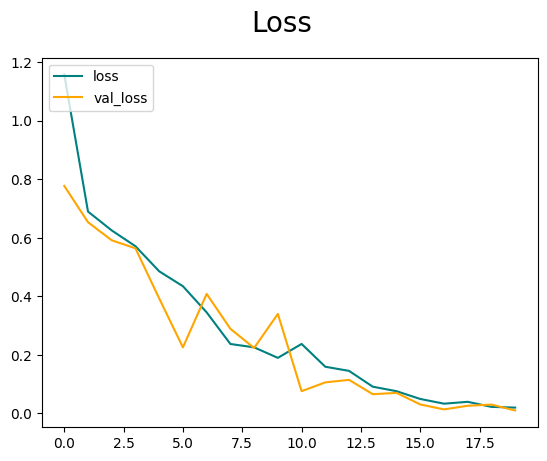

In [83]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

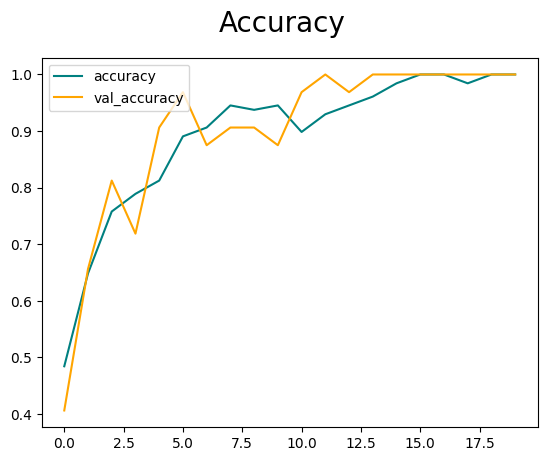

In [84]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluation

In [85]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [86]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [87]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [88]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


## Test

In [89]:
import cv2

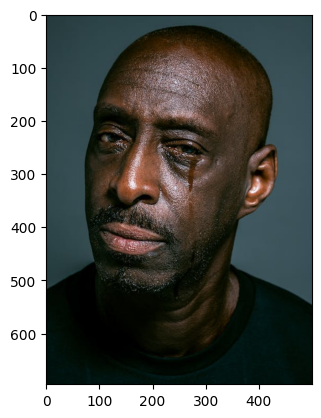

In [129]:
img = cv2.imread('sadtest.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

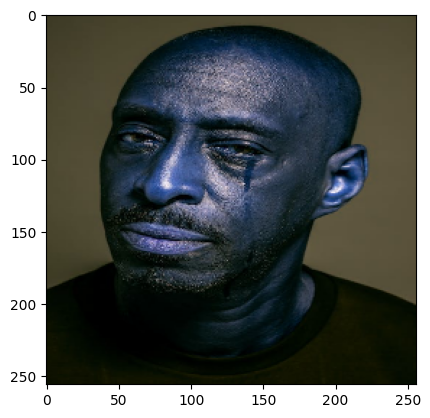

In [130]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [131]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [132]:
yhat

array([[0.9635651]], dtype=float32)

In [133]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


In [134]:
from tensorflow.keras.models import load_model

In [135]:
model.save(os.path.join('models','imageclassifier.h5'))

In [136]:
new_model = load_model('m''imageclassifier.h5')

OSError: SavedModel file does not exist at: imageclassifier.h5\{saved_model.pbtxt|saved_model.pb}